Details:

https://academic.oup.com/jnci/article/104/4/311/979947

> Single sample predictors (SSPs) and Subtype classification models (SCMs) are gene expression–based classifiers used to identify the four primary molecular subtypes of breast cancer (basal-like, HER2-enriched, luminal A, and luminal B). SSPs use hierarchical clustering, followed by nearest centroid classification, based on large sets of tumor-intrinsic genes. SCMs use a mixture of Gaussian distributions based on sets of genes with expression specifically correlated with three key breast cancer genes (estrogen receptor [ER], HER2, and aurora kinase A [AURKA]). The aim of this study was to compare the robustness, classification concordance, and prognostic value of these classifiers with those of a simplified three-gene SCM in a large compendium of microarray datasets.

AURKA

ER is ESR1 (Source: https://www.genecards.org/cgi-bin/carddisp.pl?gene=ESR1)

HER2 is ERBB2 (Source: https://www.genecards.org/cgi-bin/carddisp.pl?gene=ERBB2)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Customize this for each notebook

In [15]:
pd.read_csv(index_df_file)['train'].sum()

1903

In [2]:
OUTPUT_DIR='Three-Gene-Model-Underspecified/'
#OPTIONS={'seed':0}
data_df_file = '/disk/metabric/underspecification/data_df.csv'
target_df_file = '/disk/metabric/underspecification/targets_df.csv'
cluster = 1
index_i = 0
index_df_file = f'/disk/metabric/underspecification/index_df_{cluster}_{index_i}.csv'
#OPTIONS={'data_df_file':data_df_file.replace("/",".")}
#PREFIX="_".join([f"{key}={OPTIONS[key]}" for key in OPTIONS.keys()])
RESULTS={}
PREFIX="PCA_Shifted"

In [3]:
from pathlib import Path
home = str(Path.home())

In [4]:
KNOWLEDGE_LIB=f'{home}/knowledgelib'

In [5]:
from IPython.display import display, Markdown, Latex
import sys
sys.path.insert(0,f'{KNOWLEDGE_LIB}')
import pyknowledge
import pandas as pd
import scipy.io
import pandas as pd
import numpy as np
import joblib

## Load the input data

In [6]:
## Customize this load to read in the data and format it with the correct columns
def load_data_all(data_df_file,target_df_file):
    df = pd.read_csv(data_df_file,index_col=0)
    target_df = pd.read_csv(target_df_file,index_col=0)
    df['target'] = target_df.idxmax(axis=1).astype(int)+1
    df['Subtype'] = df.target.map({1:'Basal',2:'HER2+',3:'LumA',4:'LumB',5:'Normal Like',6:'Normal'})
    df['color'] = df.target.map({1:'red',2:'green',3:'purple',4:'cyan',5:'blue',6:'green'})
    df['graph_color'] = df.target.map({1:'#FFFFFF',2:'#F5F5F5',3:'#FFFAFA',4:'#FFFFF0',5:'#FFFAF0',6:'#F5FFFA'})
    return df

def load_data_train(df,index_df_file):
    index_df = pd.read_csv(index_df_file,index_col=0)
    return df.loc[index_df['train']]

def load_data_val(df,index_df_file):
    index_df = pd.read_csv(index_df_file,index_col=0)
    return df.loc[index_df['validation']]

In [7]:
df_all = load_data_all(data_df_file,target_df_file)

In [8]:
df_all.head()

SCGB2A2     MUCL1   SCGB1D2       PIP  LOC648852    DNAJA2      TFF3  \
0  0.167386  0.059130  0.056908  0.078110   0.089799  0.077069  0.295335   
1  0.959390  0.299562  0.560931  0.219774   0.498808  0.665585  0.865601   
2  0.965146  0.100358  0.750350  0.031331   0.151938  0.058809  0.852639   
3  0.838160  0.225737  0.377932  0.373953   0.548262  0.087369  0.622031   
4  0.751836  0.229962  0.627551  0.465012   0.358217  0.695944  0.660521   

      S100P      CPB1   CEACAM6  ...  LOC647149  LOC642453  LOC652100  \
0  0.092165  0.196660  0.092972  ...   0.622909   0.366555   0.410033   
1  0.615710  0.065395  0.201567  ...   0.554648   0.347961   0.290824   
2  0.426401  0.268281  0.736134  ...   0.598121   0.327412   0.335659   
3  0.373181  0.066093  0.110221  ...   0.446949   0.298484   0.454839   
4  0.538277  0.501089  0.210273  ...   0.597178   0.260995   0.327041   

   LOC646050  LOC644912  LOC652294  target      Subtype   color  graph_color  
0   0.288583   0.261417   0.510969       6       Normal   green      #F5FFFA  
1   0.436012   0.367912   0.642909       4         LumB    cyan      #FFFFF0  
2   0.720083   0.442122   0.217318       4         LumB    cyan      #FFFFF0  
3   0.336582   0.292038   0.504362       5  Normal Like    blue      #FFFAF0  
4   0.269492   0.253394   0.489452       3         LumA  purple      #FFFAFA  

[5 rows x 20004 columns]

In [9]:
df_all.Subtype.value_counts() # basal-like, HER2-enriched, luminal A, and luminal B

LumA           721
LumB           491
Basal          330
HER2+          239
Normal Like    202
Normal         150
Name: Subtype, dtype: int64

In [10]:
df = load_data_train(df_all,index_df_file)

In [11]:
index_df_file

'/disk/metabric/underspecification/index_df_1_0.csv'

In [12]:
df.tail()

SCGB2A2     MUCL1   SCGB1D2       PIP  LOC648852    DNAJA2      TFF3  \
2128  0.250295  0.069112  0.109990  0.959773   0.491332  0.093527  0.844124   
2129  0.564043  0.957861  0.303368  0.959773   0.641048  0.079548  0.593716   
2130  0.458633  0.880589  0.148531  0.515218   0.042985  0.085828  0.599009   
2131  0.972699  0.829901  0.948171  0.885777   0.761144  0.067213  0.964329   
2132  0.203717  0.187967  0.155515  0.048937   0.035567  0.635776  0.019951   

         S100P      CPB1   CEACAM6  ...  LOC647149  LOC642453  LOC652100  \
2128  0.174584  0.894478  0.355742  ...   0.704120   0.365854   0.505318   
2129  0.797331  0.084227  0.146556  ...   0.475482   0.409562   0.277581   
2130  0.793125  0.560906  0.363593  ...   0.448720   0.291359   0.280075   
2131  0.514316  0.139669  0.657373  ...   0.513341   0.386725   0.372532   
2132  0.852991  0.054393  0.123137  ...   0.415761   0.416261   0.297260   

      LOC646050  LOC644912  LOC652294  target      Subtype   color  \
2128   0.606349   0.563746   0.363004       3         LumA  purple   
2129   0.211428   0.436295   0.175427       5  Normal Like    blue   
2130   0.285685   0.397740   0.399417       2        HER2+   green   
2131   0.282139   0.232292   0.353497       5  Normal Like    blue   
2132   0.175033   0.270067   0.364297       1        Basal     red   

      graph_color  
2128      #FFFAFA  
2129      #FFFAF0  
2130      #F5F5F5  
2131      #FFFAF0  
2132      #FFFFFF  

[5 rows x 20004 columns]

In [14]:
df_val = load_data_val(df_all,index_df_file)
#df_val = df_all.iloc[len(df):(len(df)+170),:]
df_val

SCGB2A2     MUCL1   SCGB1D2       PIP  LOC648852    DNAJA2      TFF3  \
22    0.747782  0.828259  0.536930  0.869598   0.391326  0.076634  0.667701   
87    0.884064  0.762559  0.661403  0.572207   0.685499  0.091958  0.832017   
219   0.828312  0.734615  0.646206  0.773210   0.189233  0.043499  0.726126   
221   0.447530  0.106031  0.172275  0.451257   0.306799  0.055278  0.307705   
324   1.000000  0.771643  0.751472  0.827085   0.665237  0.103551  0.763149   
515   0.475408  0.792465  0.269216  0.646452   0.124805  0.067548  0.462168   
702   0.835083  0.804172  0.639421  0.818035   0.404091  0.051840  0.590080   
741   0.802845  0.923052  0.611966  0.850915   0.177258  0.569555  0.328324   
762   0.677305  0.432445  0.553483  0.625381   0.184250  0.076500  0.607892   
784   0.858607  0.318116  0.831132  0.663509   0.104512  0.044765  0.609582   
786   0.475666  0.431118  0.202638  0.323869   0.032223  0.064052  0.213186   
790   0.954644  0.845848  0.819052  0.727712   0.172287  0.739328  0.595007   
800   0.535522  0.107890  0.379587  0.441205   0.166006  0.082800  0.269193   
858   0.645170  0.638158  0.504082  0.605600   0.121698  0.094286  0.569544   
866   0.807891  0.799476  0.547247  0.863490   0.314733  0.089451  0.814350   
1015  0.915500  0.891605  0.766302  0.707215   0.488039  0.062596  0.836710   
1221  0.929806  0.688198  0.711898  0.747774   0.284861  0.658957  0.679161   
1244  0.857018  0.662075  0.646311  0.801069   0.280093  0.082312  0.643038   
1266  0.530491  0.705490  0.397053  0.731961   0.094118  0.512928  0.378402   
1309  0.916447  0.700961  0.729357  0.828244   0.334723  0.057157  0.654962   
1320  0.580600  0.757845  0.260061  0.757379   0.037990  0.092676  0.447964   
1394  0.968979  0.795297  0.869635  0.733814   0.878494  0.073460  0.845095   
1631  0.860883  0.717880  0.818295  0.743265   0.501247  0.057972  0.769336   
1756  0.208951  0.261051  0.083869  0.470174   0.098194  0.022631  0.302393   
1779  0.963745  0.860819  0.931727  0.949093   0.707034  0.082159  0.824495   
1833  0.648155  0.732238  0.500593  0.849725   0.047294  0.080936  0.616693   
1912  0.733414  0.568182  0.569717  0.526929   0.334323  0.064521  0.681765   
1920  0.643422  0.620924  0.346050  0.327905   0.042677  0.657814  0.431697   
2097  0.906492  0.899556  0.820381  0.950962   0.427143  0.100089  0.628987   
2115  0.721353  0.896169  0.328089  0.701177   0.306128  0.058194  0.746925   

         S100P      CPB1   CEACAM6  ...  LOC647149  LOC642453  LOC652100  \
22    0.108133  0.070139  0.182027  ...   0.523092   0.451835   0.393705   
87    0.218462  0.245316  0.339052  ...   0.282802   0.295199   0.441393   
219   0.117082  0.141472  0.356676  ...   0.462235   0.398299   0.491340   
221   0.656523  0.062849  0.251658  ...   0.589630   0.221586   0.308017   
324   0.072578  0.114757  0.070498  ...   0.383472   0.449637   0.338676   
515   0.455307  0.081913  0.353811  ...   0.415309   0.395767   0.389438   
702   0.258421  0.074261  0.127480  ...   0.275760   0.375267   0.419652   
741   0.163095  0.270256  0.134977  ...   0.612584   0.562933   0.317555   
762   0.078218  0.131724  0.071483  ...   0.650018   0.327601   0.270353   
784   0.112945  0.174489  0.123105  ...   0.393639   0.324522   0.233380   
786   0.090034  0.058645  0.217329  ...   0.767717   0.527623   0.259140   
790   0.373666  0.128137  0.508391  ...   0.636239   0.313800   0.279912   
800   0.148637  0.223890  0.110791  ...   0.633631   0.243187   0.449279   
858   0.081254  0.133935  0.091946  ...   0.365777   0.446535   0.487118   
866   0.075309  0.128030  0.449503  ...   0.309756   0.336421   0.262364   
1015  0.195484  0.142595  0.153643  ...   0.627824   0.367313   0.202353   
1221  0.184805  0.312080  0.248670  ...   0.626252   0.377263   0.325102   
1244  0.254054  0.143337  0.132757  ...   0.550005   0.271906   0.371466   
1266  0.220894  0.179943  0.089990  ...   0.404602   0.475693   0.490534   
1309  0.052811  0.164816  0.123815  .

## Knowledge

#### Genes

In [15]:
knowledge_genes = ["ERBB2","ESR1","AURKA"]

In [16]:
genes_df = pyknowledge.common.subset_columns(df,knowledge_genes)
genes_df.head()

ESR1     AURKA     ERBB2
0  0.247511  0.022905  0.165756
1  0.748999  0.299310  0.305906
2  0.828680  0.209436  0.399763
3  0.688980  0.396504  0.425207
4  0.803549  0.371463  0.423394

In [17]:
genes_df_all = pyknowledge.common.subset_columns(df_all,knowledge_genes+["Subtype"])
genes_df_all.head()

ESR1     AURKA     ERBB2      Subtype
0  0.247511  0.022905  0.165756       Normal
1  0.748999  0.299310  0.305906         LumB
2  0.828680  0.209436  0.399763         LumB
3  0.688980  0.396504  0.425207  Normal Like
4  0.803549  0.371463  0.423394         LumA

In [18]:
genes_df_all.to_csv('genes_df_all.csv')

In [19]:
genes_df_all['Subtype'].value_counts()

LumA           721
LumB           491
Basal          330
HER2+          239
Normal Like    202
Normal         150
Name: Subtype, dtype: int64

## EDA

### Each gene individually

In [20]:
source = genes_df.join(df[['Subtype','target']]).melt(id_vars=['Subtype','target'])
source.columns = ["Subtype","target","Gene","Value"]
counts = source.groupby('Subtype')['target'].count().to_frame()
counts.columns = ['Count']
source = source.set_index('Subtype').join(counts).reset_index()
# use the url approach to keep notebook smaller
#url = f'{OUTPUT_DIR}/{PREFIX}_three_gene_model_to_graph_fig1.json'
#pyknowledge.plot.prepare_url(source,url)
# TODO: Figure out what happened to this graph
#pyknowledge.plot.histogram_1(url,'Value','Subtype','Gene',file=f'{OUTPUT_DIR}/{PREFIX}_three_gene_model_to_graph_fig1.png')

## Pipeline

In [21]:
transformer = pyknowledge.transformers.ScaleTransformer()
methods = list(transformer.distributions.set_index('method').index)
methods

['Unscaled data',
 'Data after standard scaling',
 'Data after min-max scaling',
 'Data after max-abs scaling',
 'Data after robust scaling',
 'Data after power transformation (Yeo-Johnson)',
 'Data after power transformation (Box-Cox)',
 'Data after quantile transformation (uniform pdf)',
 'Data after quantile transformation (gaussian pdf)',
 'Data after sample-wise L2 normalizing']

In [22]:
import copy
import itertools
import json
from sklearn.pipeline import Pipeline

# Here you define your pipeline
pipe_factory = [['scaler',  lambda params: pyknowledge.transformers.ScaleTransformer(**params)],
                ['feature', lambda params: pyknowledge.transformers.FeatureSelector(**params)],
                ['knn', lambda params: pyknowledge.transformers.KNNTransformer(**params)]]
                #['distribution', lambda params: pyknowledge.transformers.DistributionTransformer(**params)]]

# Here you specify what arguments you want to search across
param_grid = {
    'scaler__method': ['Unscaled data',
                       'Data after standard scaling',
                       'Data after min-max scaling',
                       'Data after robust scaling'
                      ],
    'feature__columns': [knowledge_genes]
}

def grid_search(X,sub_types,pipe_factory,param_grid,sub_type_subset=None):
    test_dfs = []
    
    grouped = {}
    for key in param_grid.keys():
        key2,key3 = key.split("__")
        if key2 not in grouped:
            grouped[key2] = {}
        grouped[key2][key3] = param_grid[key]
    n = []

    for k in grouped.keys():
        n1 = []
        for k2 in grouped[k].keys():
            for v in grouped[k][k2]:
                n1.append((k,k2,v))
        n.append(n1)
    

    param_options = list(itertools.product(*n))
    
    if sub_type_subset is not None:
        mask = sub_types.isin(sub_type_subset)
        X = X.loc[mask]
        sub_types = sub_types[mask]

    results = None

    #print(param_options[0:3], '\n\n\n')
    for param_options1 in param_options:
        
        steps = []
        step_params = {}
        for step_name,func in pipe_factory:
            #print(step_name, func)
            cloned_params = {}
            for k1,k2,value in param_options1:
                #print(k1, k2, value)
                if k1 == step_name:
                    cloned_params[k2] = value
                    step_params[f"{step_name}__{k2}"] = value
            steps.append((step_name,func(cloned_params)))

        index_cols = list(step_params.keys())
        results1 = pd.DataFrame([],columns=['obj1']+index_cols)
        for k in index_cols:
            v = step_params[k]
            if type(v) == list:
                v = tuple(v)
            results1.loc[0,k] = v

        pipe = Pipeline(steps)
        pipe.fit(X,sub_types)
        distances, indices, labels = pipe.transform(X)
        
        # Our objective is how many of the neighbors are of the same subtype when using a scaling them.
        sum_obj = 0
        c = 0
        for i,sub_type in enumerate(sub_types):
            count = np.sum(labels[i,:] == sub_type)
            sum_obj += count
        obj1 = sum_obj/len(sub_types)/labels.shape[1]

        results1.loc[0,'obj1'] = obj1
        
        results1.set_index(index_cols,inplace=True)
        
        if results is None:
            results = results1
        else:
            results = results.append(results1)
            
    return results.infer_objects()

In [23]:
genes_df_sample = genes_df.copy()
sub_type_subset=['Normal like', 'HER2+', 'LumB', 'LumA']
results = grid_search(genes_df_sample,df.loc[genes_df_sample.index]['Subtype'],pipe_factory,param_grid,sub_type_subset=sub_type_subset)

In [24]:
genes_df_sample.describe() # Data is already scaled

ESR1        AURKA        ERBB2
count  1903.000000  1903.000000  1903.000000
mean      0.545655     0.343165     0.435994
std       0.268422     0.136712     0.149185
min       0.000000     0.016906     0.000000
25%       0.343748     0.238447     0.352719
50%       0.628038     0.329736     0.407319
75%       0.754881     0.434254     0.471021
max       1.000000     1.000000     1.000000

In [25]:
results

obj1
scaler__method              feature__columns              
Unscaled data               (ERBB2, ESR1, AURKA)  0.691643
Data after standard scaling (ERBB2, ESR1, AURKA)  0.685341
Data after min-max scaling  (ERBB2, ESR1, AURKA)  0.690243
Data after robust scaling   (ERBB2, ESR1, AURKA)  0.690476

In [26]:
for_latex = results.reset_index()
for_latex.columns = ['Scaling method','Genes','Leave-one-out CV']
print(for_latex.to_latex())

\begin{tabular}{lllr}
\toprule
{} &               Scaling method &                 Genes &  Leave-one-out CV \\
\midrule
0 &                Unscaled data &  (ERBB2, ESR1, AURKA) &          0.691643 \\
1 &  Data after standard scaling &  (ERBB2, ESR1, AURKA) &          0.685341 \\
2 &   Data after min-max scaling &  (ERBB2, ESR1, AURKA) &          0.690243 \\
3 &    Data after robust scaling &  (ERBB2, ESR1, AURKA) &          0.690476 \\
\bottomrule
\end{tabular}



In [27]:
RESULTS['grid_search_results'] = results

## Get the best parameters

In [28]:
best_params = {}
best = results['obj1'].idxmax()
for i,c in enumerate(results.index.names):
    best_params[c] = best[i]
best_params

{'scaler__method': 'Unscaled data',
 'feature__columns': ('ERBB2', 'ESR1', 'AURKA')}

In [29]:
RESULTS['best_params'] = best_params

In [30]:
steps = []
for name,func in pipe_factory:
    params = {}
    for key in best_params.keys():
        fields = key.split("__")
        if f"{name}__" in key:
            if type(best_params[key]) == tuple:
                best_params[key] = list(best_params[key])
            params[fields[1]] = best_params[key]
    steps.append((name,func(params)))

X = genes_df_sample.copy()
sub_types = df.loc[genes_df_sample.index]['Subtype'].copy()
if sub_type_subset is not None:
    mask = sub_types.isin(sub_type_subset)
    X = X.loc[mask]
    sub_types = sub_types[mask]
    df_mask = df.loc[genes_df_sample.index].loc[mask]
    
pipeline = Pipeline(steps)
pipeline.fit(X,sub_types)

Pipeline(steps=[('scaler', ScaleTransformer()),
                ('feature',
                 FeatureSelector(columns=['ERBB2', 'ESR1', 'AURKA'])),
                ('knn', KNNTransformer())])

In [31]:
X.shape

(1428, 3)

In [32]:
RESULTS['pipeline'] = None # TODO: fix this so it pickles

In [33]:
distances, indices, labels = pipeline.transform(X)

In [34]:
labels

array([['LumB', 'LumB', 'LumA'],
       ['LumA', 'LumA', 'LumB'],
       ['LumB', 'LumB', 'LumA'],
       ...,
       ['LumA', 'LumA', 'LumA'],
       ['LumA', 'LumA', 'LumA'],
       ['LumA', 'LumB', 'HER2+']], dtype=object)

In [35]:
labels

array([['LumB', 'LumB', 'LumA'],
       ['LumA', 'LumA', 'LumB'],
       ['LumB', 'LumB', 'LumA'],
       ...,
       ['LumA', 'LumA', 'LumA'],
       ['LumA', 'LumA', 'LumA'],
       ['LumA', 'LumB', 'HER2+']], dtype=object)

### Visualize our graph

In [36]:
from IPython.display import Image

import networkx as nx

A = pd.DataFrame(index=df_all.index,columns=df_all.index)

G = nx.Graph()
for ix in df.index:
    c = df.loc[ix,'graph_color']
    G.add_node(ix,color='black',style='filled',fillcolor=c)

for i in range(len(indices)):
    iix = df_mask.index[i] # this is wonky one
    for j,ix in enumerate(indices[i,:]):
        jix = df_mask.index[indices[i,j]]
        if labels[i,j] == sub_types.iloc[i]:
            G.add_edge(iix,jix)
            A.loc[iix,jix] = 1
            A.loc[jix,iix] = 1

In [37]:
RESULTS['A'] = A

In [38]:
len(df)

1903

In [39]:
len(df_mask)

1428

In [40]:
A.to_csv(f"{OUTPUT_DIR}{PREFIX}_graph.csv",)

In [41]:
f"{OUTPUT_DIR}{PREFIX}_graph.csv"

'Three-Gene-Model-Underspecified/PCA_Shifted_graph.csv'

/opt/tljh/user/lib/python3.7/site-packages/pygraphviz/agraph.py:1390: RuntimeWarning: dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.40607 to fit

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


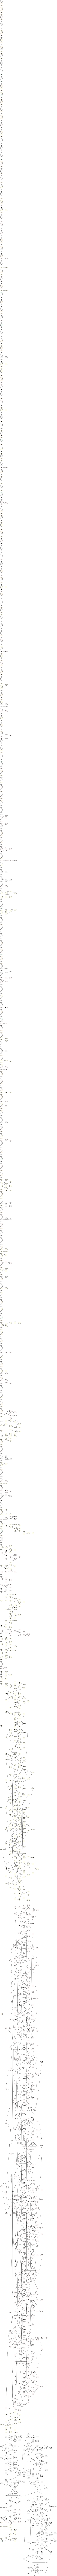

In [42]:
def save(A,file="graph.png"):
    g = A.draw(format=file.split(".")[-1], prog='dot')
    open(file,"wb").write(g)
    return Image(g)

pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')
A = nx.nx_agraph.to_agraph(G)
A.graph_attr["rankdir"] = "LR"
# draw it in the notebook
save(A,file=f"{OUTPUT_DIR}{PREFIX}_graph.png")

In [43]:
!mkdir {OUTPUT_DIR}{PREFIX}_graphs

mkdir: cannot create directory ‘Three-Gene-Model-Underspecified/PCA_Shifted_graphs’: File exists


In [44]:
graphs = list(G.subgraph(c).copy() for c in nx.connected_components(G))

for i,graph in enumerate(graphs):
    pos = nx.drawing.nx_agraph.graphviz_layout(graph, prog='dot')
    A = nx.nx_agraph.to_agraph(graph)
    A.graph_attr["rankdir"] = "LR"
    # draw it in the notebook
    save(A,file=f"{OUTPUT_DIR}{PREFIX}_graphs/graph_{i}.png")

In [45]:
import joblib
joblib.dump(RESULTS,f'{OUTPUT_DIR}{PREFIX}_RESULTS.joblib.z')

['Three-Gene-Model-Underspecified/PCA_Shifted_RESULTS.joblib.z']

### Validation

In [46]:
df_val.columns

Index(['SCGB2A2', 'MUCL1', 'SCGB1D2', 'PIP', 'LOC648852', 'DNAJA2', 'TFF3',
       'S100P', 'CPB1', 'CEACAM6',
       ...
       'LOC647149', 'LOC642453', 'LOC652100', 'LOC646050', 'LOC644912',
       'LOC652294', 'target', 'Subtype', 'color', 'graph_color'],
      dtype='object', length=20004)

In [47]:
X = pyknowledge.common.subset_columns(df_val,knowledge_genes)

In [48]:
X

ESR1     AURKA     ERBB2
22    0.366398  0.101016  0.434938
87    0.648411  0.088358  0.374252
219   0.594763  0.135179  0.407577
221   0.500212  0.178972  0.290990
324   0.476011  0.095692  0.452398
515   0.449225  0.152837  0.293241
702   0.334930  0.165608  0.347248
741   0.664412  0.076931  0.383147
762   0.390158  0.085598  0.262202
784   0.366434  0.068874  0.350935
786   0.278637  0.207190  0.213599
790   0.598262  0.208793  0.310868
800   0.285196  0.083537  0.218199
858   0.302228  0.013562  0.256845
866   0.596350  0.135907  0.466397
1015  0.622642  0.153116  0.384021
1221  0.693928  0.090196  0.431705
1244  0.766857  0.277702  0.341607
1266  0.421258  0.064721  0.251301
1309  0.777566  0.073078  0.447566
1320  0.431990  0.084952  0.236987
1394  0.495754  0.042234  0.353523
1631  0.449644  0.066571  0.326184
1756  0.292912  0.240550  0.191238
1779  0.595902  0.071426  0.381672
1833  0.472719  0.082613  0.398592
1912  0.402553  0.051591  0.440923
1920  0.138070  0.100017  0.340639
2097  0.666211  0.038879  0.311642
2115  0.145756  0.289598  0.805700

In [49]:
distances, indices, labels = pipeline.transform(X)

In [50]:
A = pd.DataFrame(index=df_all.index,columns=df_all.index)

for i in range(len(indices)):
    iix = df_val.index[i]
    for j,ix in enumerate(indices[i,:]):
        jix = df_mask.index[indices[i,j]]
        A.loc[iix,jix] = 1
        A.loc[jix,iix] = 1

In [51]:
A.shape

(2133, 2133)

In [52]:
A.stack()

22    413     1
      654     1
      994     1
25    866     1
77    87      1
             ..
2097  2032    1
2105  1221    1
2115  949     1
      1272    1
      1366    1
Length: 180, dtype: object

In [53]:
A.to_csv(f"{OUTPUT_DIR}{PREFIX}_graph_val.csv",)

In [54]:
f"{OUTPUT_DIR}{PREFIX}_graph_val.csv"

'Three-Gene-Model-Underspecified/PCA_Shifted_graph_val.csv'

In [55]:
A

0    1    2    3    4    5    6    7    8    9     ... 2123 2124 2125  \
0     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
3     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
4     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2128  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2129  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2130  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2131  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2132  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   

     2126 2127 2128 2129 2130 2131 2132  
0     NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1     NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2     NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3     NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4     NaN  NaN  NaN  NaN  NaN  NaN  NaN  
...   ...  ...  ...  ...  ...  ...  ...  
2128  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2129  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2130  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2131  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2132  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[2133 rows x 2133 columns]